In [30]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.circuit.library import RYGate
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime.options import EstimatorOptions
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_experiments.library import StateTomography
import matplotlib.pyplot as plt


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    token="API_key_here",
    instance="open-instance",
    overwrite=True
)

In [ ]:
Wservice = QiskitRuntimeService()

In [33]:
backend = service.least_busy(simulator=False, operational=True)
print(f"Running on: {backend.name}")
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

Running on: ibm_fez


In [ ]:
def verify_identities():
    print("Verifying Gate Identities")
    identities = [
        ("Fredkin", lambda qc: [qc.x([0, 2]), qc.cswap(0, 1, 2), qc.cswap(0, 1, 2)], 
                   lambda qc: qc.x([0, 2])),
        ("CX X1 CX", lambda qc: [qc.cx(0,1), qc.x(0), qc.cx(0,1)], 
                     lambda qc: [qc.x(0), qc.x(1)]),
        ("CX Z1 CX", lambda qc: [qc.cx(0,1), qc.z(0), qc.cx(0,1)], 
                     lambda qc: qc.z(0)),
        ("CX Y2 CX", lambda qc: [qc.cx(0,1), qc.y(1), qc.cx(0,1)], 
                     lambda qc: [qc.z(0), qc.y(1)]),
        ("CX Y1 CX", lambda qc: [qc.cx(0,1), qc.y(0), qc.cx(0,1)], 
                     lambda qc: [qc.y(0), qc.x(1)])
    ]
    
    sampler_circs = []
    for name, lhs_ops, rhs_ops in identities:
        qc_l = QuantumCircuit(3 if "Fredkin" in name else 2)
        lhs_ops(qc_l)
        qc_l.measure_all()
        qc_r = QuantumCircuit(3 if "Fredkin" in name else 2)
        rhs_ops(qc_r)
        qc_r.measure_all()
        sampler_circs.extend([pm.run(qc_l), pm.run(qc_r)])
    sampler = Sampler(mode=backend)
    job = sampler.run(sampler_circs)
    results = job.result()
    for i in range(0, len(identities) * 2, 2):
        label = identities[i//2][0]
        counts_l = results[i].data.meas.get_counts()
        counts_r = results[i+1].data.meas.get_counts()
        
        print(f"Identity: {label}")
        print(f"  LHS: {counts_l}")
        print(f"  RHS: {counts_r}")
        display(plot_histogram([counts_l, counts_r], 
                               legend=['LHS (Experimental)', 'RHS (Target)'],
                               title=f"Verification: {label}"))

In [ ]:
def run_ghz_tests():
    print("GHZ States on 3, 4, and 5 Qubits")
    ghz_list = []
    for n in [3, 4, 5]:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(1, n):
            qc.cx(0, i)
        qc.measure_all()
        ghz_list.append(pm.run(qc))
    
    sampler = Sampler(mode=backend)
    results = sampler.run(ghz_list).result()
    
    for i, n in enumerate([3, 4, 5]):
        display(plot_histogram(results[i].data.meas.get_counts(), title=f"GHZ {n} Qubits"))

In [ ]:
def w3_circuit():
    qc = QuantumCircuit(3)
    qc.ry(2 * np.arccos(np.sqrt(2/3)), 0)
    qc.cry(2 * np.arccos(np.sqrt(1/2)), 0, 1, ctrl_state='0')
    qc.x([0, 1])
    qc.mcx([0, 1], 2)
    qc.x([0, 1])
    return qc

def w4_circuit():
    qc = QuantumCircuit(4)
    qc.ry(2 * np.arccos(np.sqrt(3/4)), 0)
    qc.cry(2 * np.arccos(np.sqrt(2/3)), 0, 1, ctrl_state='0')
    ry_gate = RYGate(2 * np.arccos(np.sqrt(1/2))).control(2, ctrl_state='00')
    qc.append(ry_gate, [0, 1, 2])
    qc.x([0, 1, 2])
    qc.mcx([0, 1, 2], 3)
    qc.x([0, 1, 2])
    return qc

#tomogoraphy for W4 was not done due to time constraints on the server
def run_w_tomography():
    print("W-State Tomography")
    for qc, name in [(w3_circuit(), "W3")]:
        print(f"Starting Tomography for {name}...")
        exp = StateTomography(qc)
        exp_data = exp.run(backend).block_for_results()
        
        density_mat = exp_data.analysis_results("state").value
        display(plot_state_city(density_mat, title=f"{name} Reconstructed Density Matrix"))
        
        if "state_fidelity" in exp_data.analysis_results():
            print(f"{name} Fidelity: {exp_data.analysis_results('state_fidelity').value:.4f}")


--- Phase 1: Verifying Gate Identities ---
Identity: Fredkin
  LHS: {'101': 3634, '111': 105, '011': 88, '100': 61, '001': 132, '010': 51, '000': 18, '110': 7}
  RHS: {'101': 3530, '100': 483, '111': 55, '110': 5, '001': 22, '000': 1}


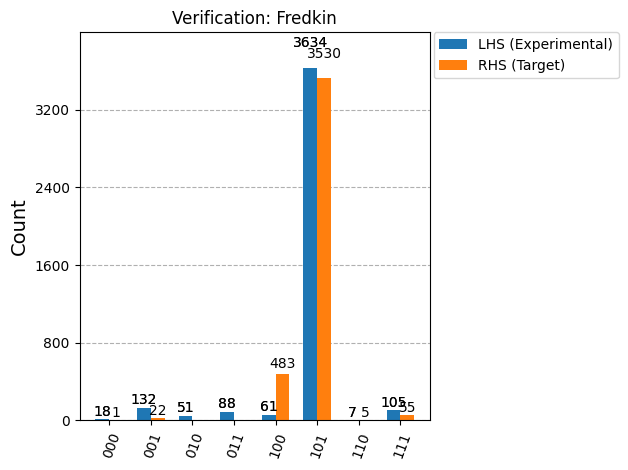

Identity: CX X1 CX
  LHS: {'11': 3000, '00': 258, '10': 675, '01': 163}
  RHS: {'11': 3446, '10': 518, '01': 109, '00': 23}


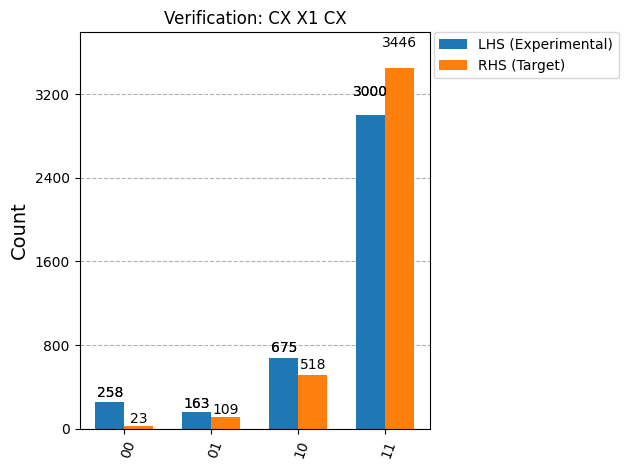

Identity: CX Z1 CX
  LHS: {'00': 3818, '10': 269, '01': 8, '11': 1}
  RHS: {'00': 4032, '10': 59, '01': 5}


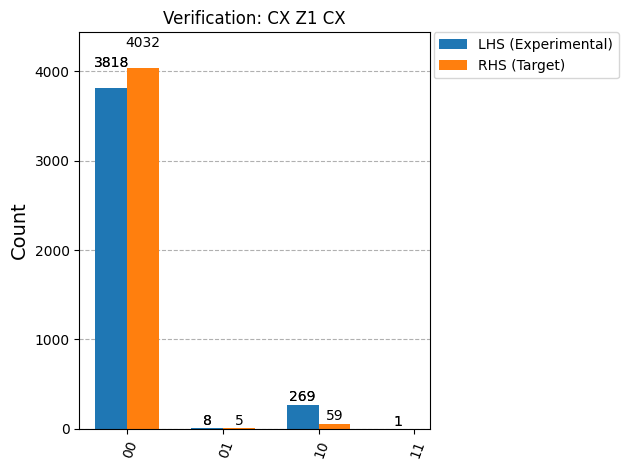

Identity: CX Y2 CX
  LHS: {'10': 3787, '00': 305, '11': 3, '01': 1}
  RHS: {'10': 3943, '00': 147, '11': 6}


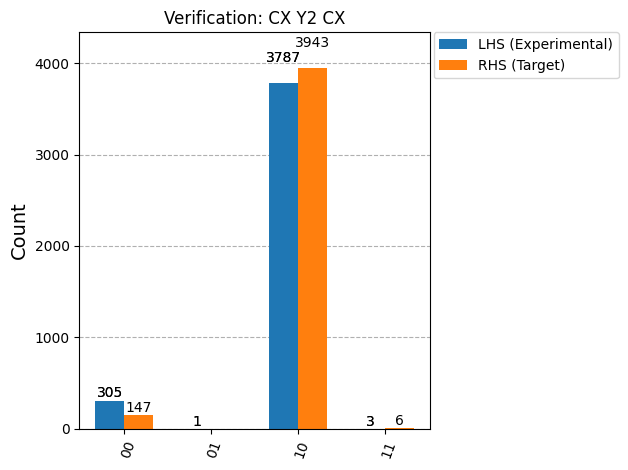

Identity: CX Y1 CX
  LHS: {'11': 3016, '01': 186, '10': 650, '00': 244}
  RHS: {'10': 439, '11': 3515, '01': 125, '00': 17}


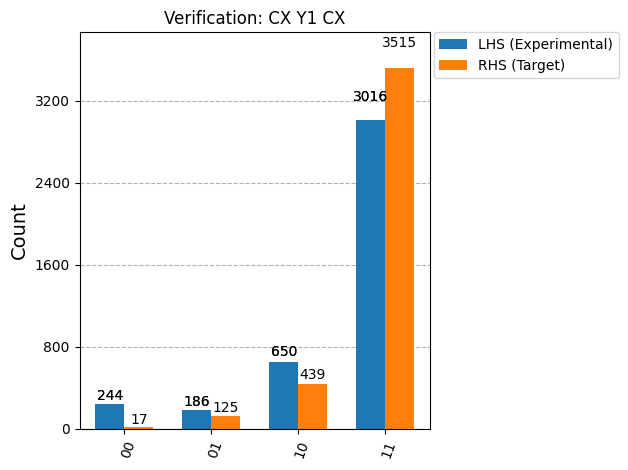


--- Phase 2: GHZ States ---


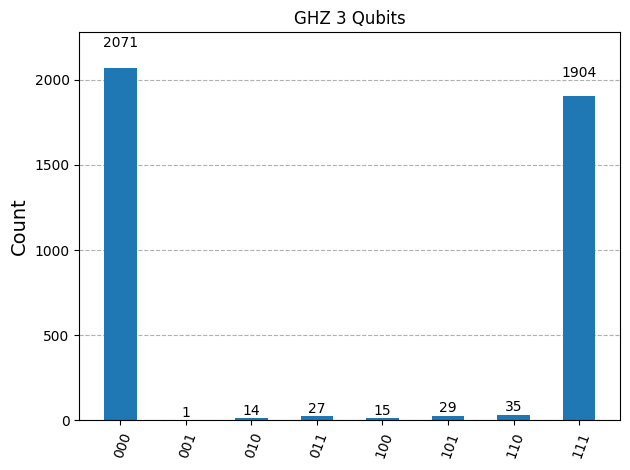

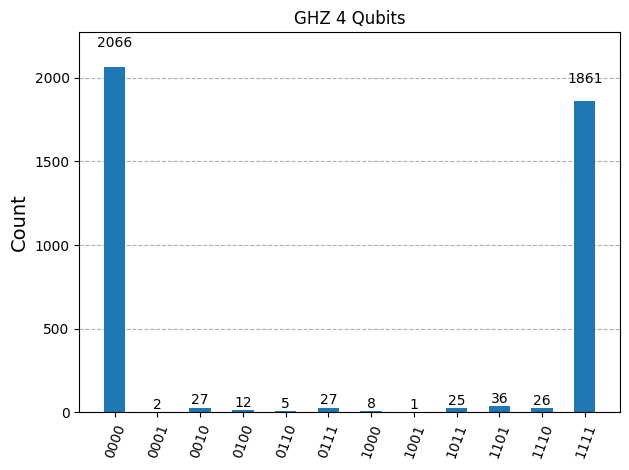

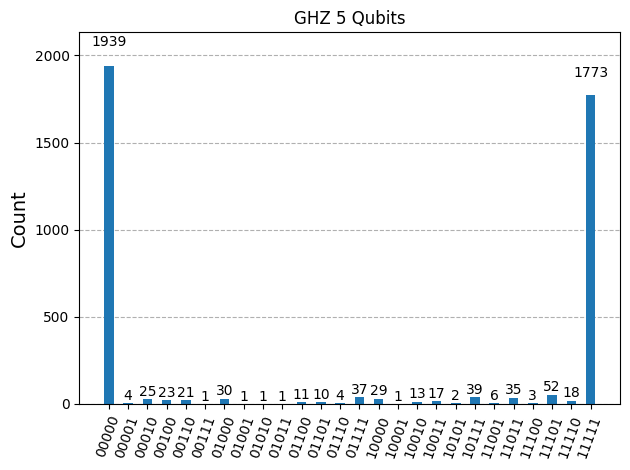


--- Phase 3: W-State Tomography ---
Starting Tomography for W3...


/var/folders/tt/f0lw_k_d15v3w5wjjv20m2c00000gn/T/ipykernel_86737/1659646449.py:29: DeprecationWarning: Leaving `dataframe` unset or setting it to `False` for `ExperimentData.analysis_results` is deprecated as of qiskit-experiments 0.9.0. Future releases may change the default to `True` and remove the option to set the value to `False`.
  density_mat = exp_data.analysis_results("state").value


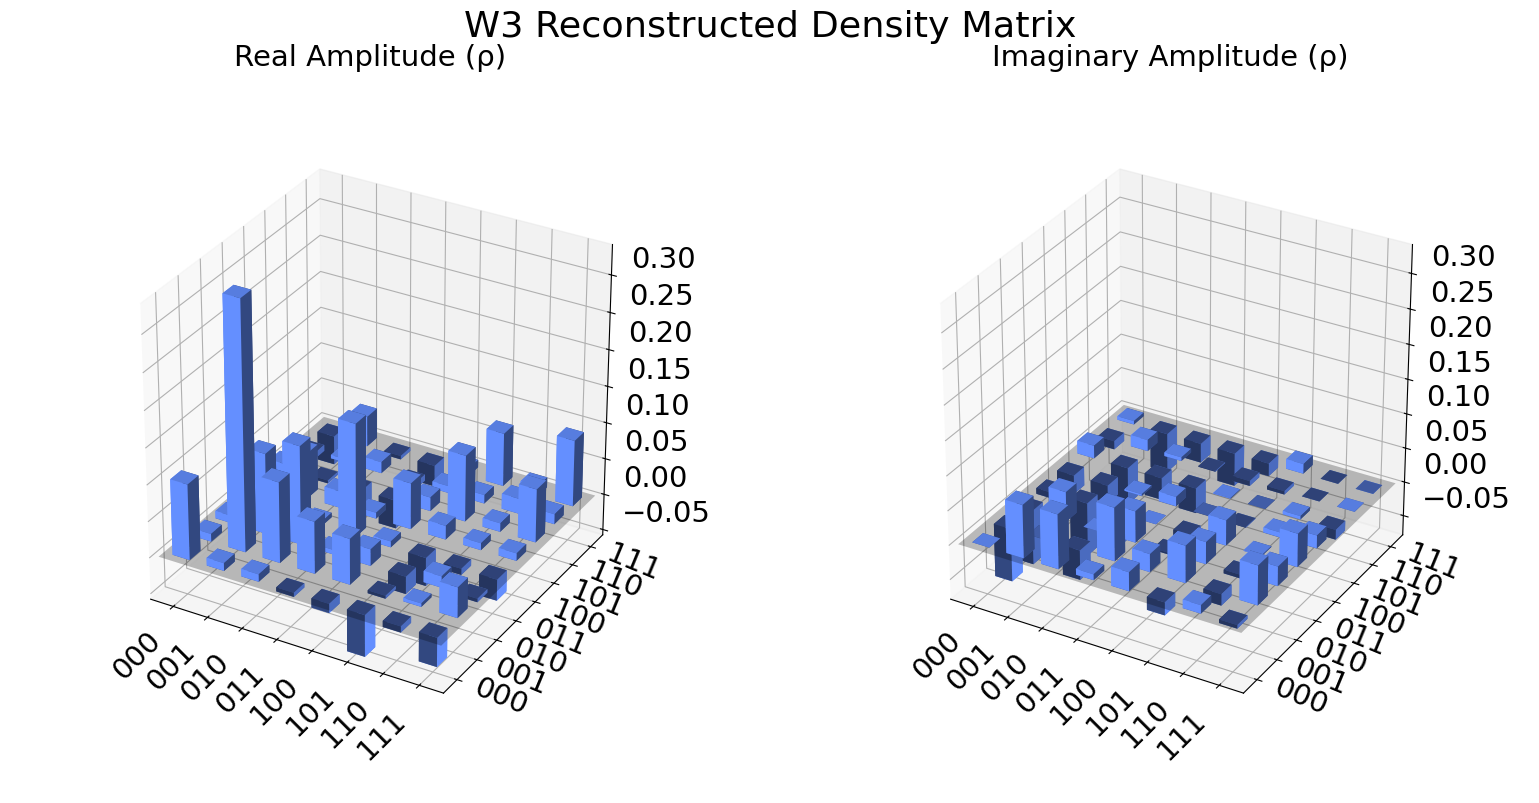

/var/folders/tt/f0lw_k_d15v3w5wjjv20m2c00000gn/T/ipykernel_86737/1659646449.py:32: DeprecationWarning: Leaving `dataframe` unset or setting it to `False` for `ExperimentData.analysis_results` is deprecated as of qiskit-experiments 0.9.0. Future releases may change the default to `True` and remove the option to set the value to `False`.
  if "state_fidelity" in exp_data.analysis_results():


In [37]:
verify_identities()
run_ghz_tests()
run_w_tomography()